In [11]:
import pandas as pd
data = pd.read_csv("/Users/kmaran3/Dropbox/MGT6203/TEMP/game_logs.csv")
threshold = len(data.columns) / 2
data = data.dropna(thresh=threshold)
data = data[data['forefeit'].isna()]
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'], format='%Y%m%d', errors='coerce')  # Convert to datetime
    data = data[data['date'] > pd.Timestamp('1961-01-01')]

mlb_team_mapping = {
    'CHA': 'CWS', 'LAA': 'LAA', 'KC1': 'KC', 'CLE': 'CLE', 'MIN': 'MIN', 'CHN': 'CHC',
    'PHI': 'PHI', 'SLN': 'STL', 'PIT': 'PIT', 'MLN': 'MIL', 'CIN': 'CIN', 'WS2': 'WSH',
    'DET': 'DET', 'NYA': 'NYY', 'BOS': 'BOS', 'SFN': 'SF', 'BAL': 'BAL', 'LAN': 'LAD',
    'NYN': 'NYM', 'HOU': 'HOU', 'CAL': 'LAA', 'ATL': 'ATL', 'OAK': 'OAK', 'SE1': 'SEA',
    'MON': 'WSH', 'KCA': 'KC', 'SDN': 'SD', 'TOR': 'TOR', 'SEA': 'SEA', 'MIL': 'MIL',
    'TEX': 'TEX', 'COL': 'COL', 'TBA': 'TB', 'FLO': 'MIA', 'ARI': 'ARI', 'ANA': 'LAA',
    'WAS': 'WSH', 'MIA': 'MIA'
}

if 'v_name' in data.columns and 'h_name' in data.columns:
    data['v_name'] = data['v_name'].map(mlb_team_mapping)
    data['h_name'] = data['h_name'].map(mlb_team_mapping)

print("Consolidated unique values in v_name:", data['v_name'].unique())
print("Consolidated unique values in h_name:", data['h_name'].unique())

data = data[["date", "day_of_week", "v_name", "v_game_number", "h_name", "h_game_number", "v_score", 'h_score', "day_night", "attendance"]]

/var/folders/12/yvdl_th13tl4mjm1qz4j380m0000gn/T/ipykernel_54033/3923272680.py:2: DtypeWarning: Columns (13,14,15,16,20,21,82,84,86,88,94,95,96,97,98,99,100,101,106,107,109,110,112,113,115,116,118,119,121,122,124,125,127,128,130,131,133,134,136,137,139,140,142,143,145,146,148,149,151,152,154,155,157,158,161) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/Users/kmaran3/Dropbox/MGT6203/TEMP/game_logs.csv")


Consolidated unique values in v_name: ['CWS' 'LAA' 'KC' 'CLE' 'MIN' 'CHC' 'PHI' 'STL' 'PIT' 'MIL' 'CIN' 'WSH'
 'DET' 'NYY' 'BOS' 'SF' 'BAL' 'LAD' 'NYM' 'HOU' 'ATL' 'OAK' 'SEA' 'SD'
 'TOR' 'TEX' 'COL' 'TB' 'MIA' 'ARI']
Consolidated unique values in h_name: ['WSH' 'BAL' 'BOS' 'DET' 'NYY' 'CIN' 'LAD' 'MIL' 'SF' 'CHC' 'STL' 'PIT'
 'CWS' 'CLE' 'PHI' 'KC' 'MIN' 'LAA' 'HOU' 'NYM' 'ATL' 'OAK' 'SD' 'SEA'
 'TEX' 'TOR' 'MIA' 'ARI' 'TB' 'COL']


In [12]:
mlb_data = data

# Convert dates to datetime for chronological operations
mlb_data['date'] = pd.to_datetime(mlb_data['date'], errors='coerce')

# Drop any rows with missing or invalid date information
mlb_data = mlb_data.dropna(subset=['date'])

# Add columns for game outcomes and score differentials
mlb_data['home_win'] = mlb_data['h_score'] > mlb_data['v_score']
mlb_data['score_diff'] = abs(mlb_data['h_score'] - mlb_data['v_score'])

# Define a function to find the last game outcome and score differential for a team
def create_lag_features(df, team_col, result_col, score_diff_col):
    # Initialize new columns
    last_game_outcome = []
    last_game_score_diff = []
    # Dictionary to track the last result and score diff for each team
    team_last_info = {}
    
    for _, row in df.iterrows():
        team = row[team_col]
        # Append the last known values or NaN if no previous record
        last_game_outcome.append(team_last_info.get(team, {}).get('outcome', None))
        last_game_score_diff.append(team_last_info.get(team, {}).get('score_diff', None))
        # Update the team's last game result and score diff in the dictionary
        team_last_info[team] = {
            'outcome': row[result_col],
            'score_diff': row[score_diff_col]
        }
    
    return last_game_outcome, last_game_score_diff

# Create lag features for the home team
mlb_data['h_last_game_outcome'], mlb_data['h_last_game_score_diff'] = create_lag_features(
    mlb_data, 'h_name', 'home_win', 'score_diff'
)

# Create lag features for the visiting team
mlb_data['v_last_game_outcome'], mlb_data['v_last_game_score_diff'] = create_lag_features(
    mlb_data, 'v_name', 'home_win', 'score_diff'
)

import pandas as pd

# Define the streak calculation function
def calculate_streaks(data, date_column, team_column, outcome_column):
    # Sort data by date
    data = data.sort_values(by=date_column)
    data['streak'] = 0
    current_streak = 0
    
    for i in range(len(data)):
        if i == 0 or data.iloc[i - 1][outcome_column] == data.iloc[i][outcome_column]:
            current_streak += 1
        else:
            current_streak = 1
        data.at[data.index[i], 'streak'] = current_streak * (1 if data.iloc[i][outcome_column] else -1)
    
    return data

# Prepare the home and visiting team data
home_data = mlb_data[['date', 'h_name', 'home_win']].rename(
    columns={'date': 'game_date', 'h_name': 'team', 'home_win': 'win'}
)
visiting_data = mlb_data[['date', 'v_name', 'home_win']].rename(
    columns={'date': 'game_date', 'v_name': 'team', 'home_win': 'win'}
)

# Adjust the outcome for visiting teams (invert the home win outcome)
visiting_data['win'] = ~visiting_data['win']

# Combine the data for streak calculations
team_data = pd.concat([home_data, visiting_data])

# Calculate streaks for each team
team_data = team_data.groupby('team').apply(
    lambda x: calculate_streaks(x, 'game_date', 'team', 'win')
).reset_index(drop=True)

# Merge the streak information back into the original dataset
# Match by team and game date to ensure correct alignment
mlb_data = mlb_data.merge(
    team_data[['game_date', 'team', 'streak']],
    how='left',
    left_on=['date', 'h_name'],
    right_on=['game_date', 'team']
).rename(columns={'streak': 'h_streak'}).drop(['game_date', 'team'], axis=1)

mlb_data = mlb_data.merge(
    team_data[['game_date', 'team', 'streak']],
    how='left',
    left_on=['date', 'v_name'],
    right_on=['game_date', 'team']
).rename(columns={'streak': 'v_streak'}).drop(['game_date', 'team'], axis=1)

mlb_data.to_csv("/Users/kmaran3/Dropbox/MGT6203/TEMP/mlb_cleaned_data.csv")



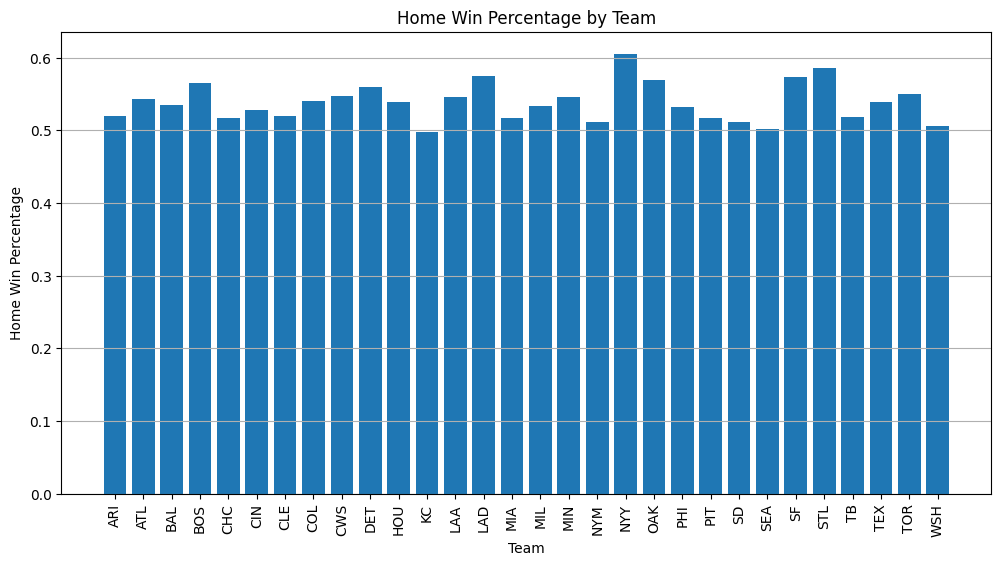

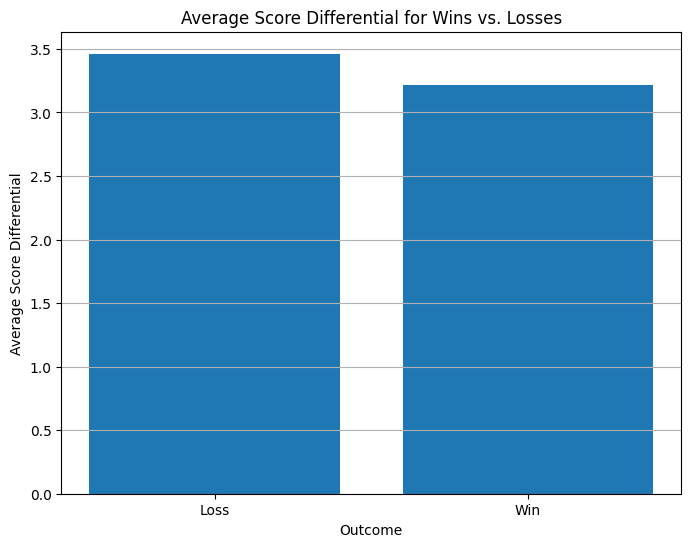

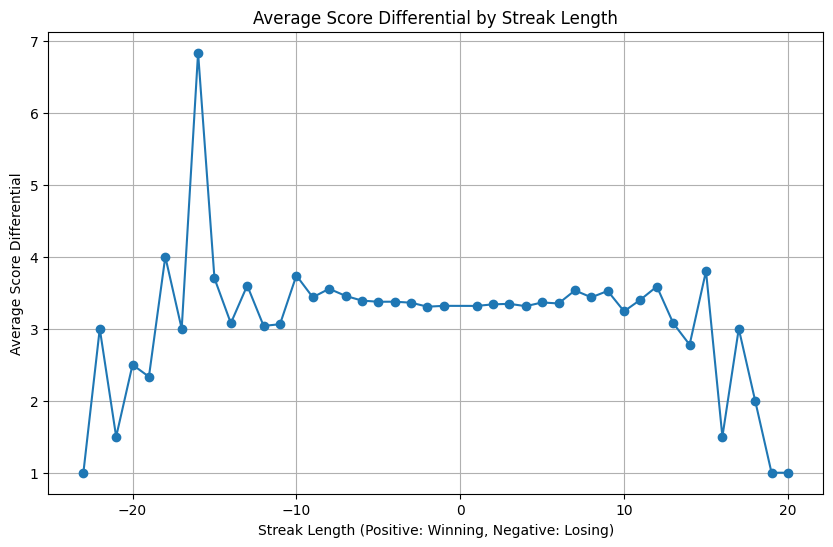

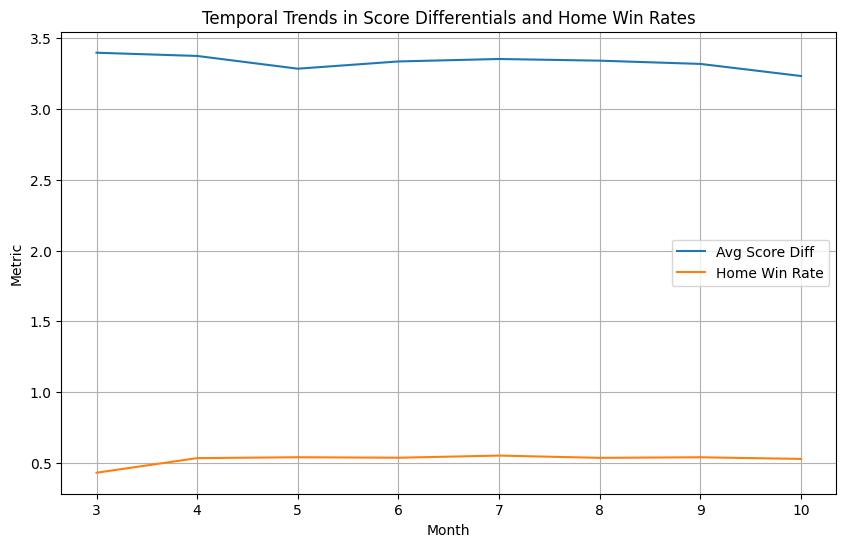

: 

In [6]:

import pandas as pd
import matplotlib.pyplot as plt


# Extract relevant columns for EDA
columns = ['date', 'v_name', 'h_name', 'v_score', 'h_score', 'v_league', 'h_league']
mlb_filtered = data[columns]

# Rename columns for easier reference
mlb_filtered = mlb_filtered.rename(columns={
    'date': 'game_date',
    'v_name': 'visiting_team',
    'h_name': 'home_team',
    'v_score': 'visiting_score',
    'h_score': 'home_score'
})

# Convert date to datetime
mlb_filtered['game_date'] = pd.to_datetime(mlb_filtered['game_date'], errors='coerce')

# Add calculated fields
mlb_filtered['home_win'] = mlb_filtered['home_score'] > mlb_filtered['visiting_score']
mlb_filtered['score_diff'] = abs(mlb_filtered['home_score'] - mlb_filtered['visiting_score'])

# Analysis 1: Team Performance Metrics
team_performance = mlb_filtered.groupby('home_team').agg(
    home_games=('home_win', 'count'),
    home_wins=('home_win', 'sum'),
    avg_score_diff=('score_diff', 'mean')
).reset_index()

team_performance['home_win_pct'] = team_performance['home_wins'] / team_performance['home_games']

# Visualization: Team Performance Metrics
plt.figure(figsize=(12, 6))
plt.bar(team_performance['home_team'], team_performance['home_win_pct'])
plt.title('Home Win Percentage by Team')
plt.xlabel('Team')
plt.ylabel('Home Win Percentage')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

# Analysis 2: Game Outcome Influences
score_diff_analysis = mlb_filtered.groupby('home_win').agg(
    avg_score_diff=('score_diff', 'mean'),
    games=('home_win', 'count')
).reset_index()

# Visualization: Game Outcome Influences
plt.figure(figsize=(8, 6))
plt.bar(['Loss', 'Win'], score_diff_analysis['avg_score_diff'])
plt.title('Average Score Differential for Wins vs. Losses')
plt.xlabel('Outcome')
plt.ylabel('Average Score Differential')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(streak_analysis['streak'], streak_analysis['avg_score_diff'], marker='o')
plt.title('Average Score Differential by Streak Length')
plt.xlabel('Streak Length (Positive: Winning, Negative: Losing)')
plt.ylabel('Average Score Differential')
plt.grid(True)
plt.show()
plt.show()

# Analysis 5: Temporal Trends
temporal_trends = mlb_filtered.groupby(mlb_filtered['game_date'].dt.month).agg(
    avg_score_diff=('score_diff', 'mean'),
    home_win_rate=('home_win', 'mean')
).reset_index()
temporal_trends.rename(columns={'game_date': 'month'}, inplace=True)

# Visualization: Temporal Trends
plt.figure(figsize=(10, 6))
plt.plot(temporal_trends['month'], temporal_trends['avg_score_diff'], label='Avg Score Diff')
plt.plot(temporal_trends['month'], temporal_trends['home_win_rate'], label='Home Win Rate')
plt.title('Temporal Trends in Score Differentials and Home Win Rates')
plt.xlabel('Month')
plt.ylabel('Metric')
plt.legend()
plt.grid()
plt.show()

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define the columns to exclude
columns_to_exclude = ['index', 'number_of_game', 'completion', 'forefeit', 'protest']

# Get the list of all column names
all_columns = data.columns

# Select columns 1-52 and exclude unwanted ones
selected_columns = [col for col in all_columns[1:52] if col not in columns_to_exclude]

# Filter the dataset to include selected columns only
model_data = data[selected_columns]

# Rename columns for clarity
model_data = model_data.rename(columns={
    'date': 'game_date',
    'h_name': 'home_team',
    'v_name': 'visiting_team',
    'h_score': 'home_score',
    'v_score': 'visiting_score'
})

# Convert game_date to datetime
model_data['game_date'] = pd.to_datetime(model_data['game_date'], errors='coerce')

# Add derived features: win/loss outcome and score difference
model_data['home_win'] = model_data['home_score'] > model_data['visiting_score']
model_data['score_diff'] = model_data['home_score'] - model_data['visiting_score']
model_data['win'] = model_data['home_win'].astype(int)  # Binary target

# Drop rows with missing values in critical columns
model_data = model_data.dropna(subset=['game_date', 'home_score', 'visiting_score'])

# Prepare feature matrix X and target vector y
X = model_data.drop(columns=['game_date', 'home_win', 'win', 'home_team', 'visiting_team'])
y = model_data['win']

# Ensure all columns in X are numeric
non_numeric_columns = X.select_dtypes(include=['object', 'category']).columns

numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())


# Convert categorical columns to one-hot encoded columns
if len(non_numeric_columns) > 0:
    X = pd.get_dummies(X, columns=non_numeric_columns, drop_first=True)

# Check for any remaining non-numeric values
if X.isnull().values.any():
    print("Warning: Missing values found in X. Filling with zeros.")
    X = X.fillna(0)  # Replace missing values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)
